In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import chi2
from sklearn import metrics

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set_theme()
plt.rcParams['figure.figsize'] = [8,8]

In [4]:
violets = pd.read_csv("violets.csv")
violets.columns

Index(['Year', 'Plot', 'Day', 'Light quantity', 'Soil moisture', 'Photoperiod',
       'Bud type', 'Bud counts', 'Min temp', 'Mean temp', 'Max temp',
       'SD temp'],
      dtype='object')

In [5]:
violets = violets[['Year','Plot','Day','Photoperiod','Bud type','Bud counts']]
violets

,Year,Plot,Day,Photoperiod,Bud type,Bud counts
0,2016,1,96,12.833333,Cleistogamous,0
1,2016,1,96,12.833333,Chasmogamous,1
2,2016,1,104,13.166667,Cleistogamous,0
3,2016,1,104,13.166667,Chasmogamous,1
4,2016,1,109,13.366667,Chasmogamous,0
...,...,...,...,...,...,...
315,2017,10,116,13.666667,Cleistogamous,0
316,2017,10,128,14.100000,Chasmogamous,0
317,2017,10,128,14.100000,Cleistogamous,18
318,2017,10,143,14.550000,Chasmogamous,0


In [6]:
chasm = violets[ violets['Bud type']=="Chasmogamous" ]
chasm["Bud"] = (violets['Bud counts'] > 0).astype('int')
chasm = chasm[["Photoperiod","Bud"]]
chasm

,Photoperiod,Bud
1,12.833333,1
3,13.166667,1
4,13.366667,0
7,13.716667,0
9,13.966667,0
...,...,...
311,13.116667,1
312,13.350000,0
314,13.666667,0
316,14.100000,0


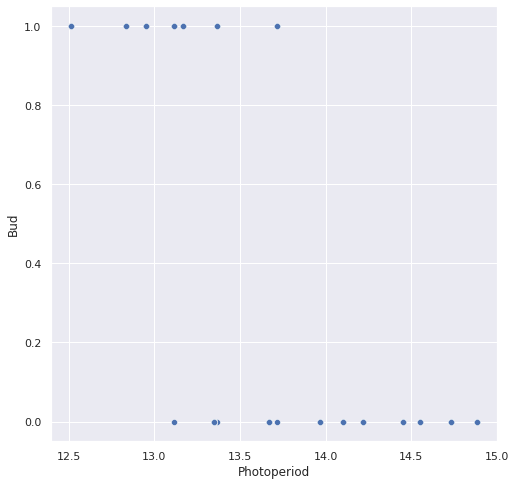

In [7]:
sns.scatterplot(data=chasm, x="Photoperiod", y="Bud")
plt.savefig("chasm.png")

In [8]:
chasm.agg( N=('Bud','size'),
           Successes=('Bud','sum'),
           Percentage=('Bud','mean'))

,Bud
N,160.00000
Successes,67.00000
Percentage,0.41875


In [9]:
pi_hat = chasm["Bud"].mean()
pi_hat

0.41875

In [10]:
chasm["Null_prob"] = (pi_hat**chasm.Bud)*((1-pi_hat)**(1-chasm.Bud))
chasm

,Photoperiod,Bud,Null_prob
1,12.833333,1,0.41875
3,13.166667,1,0.41875
4,13.366667,0,0.58125
7,13.716667,0,0.58125
9,13.966667,0,0.58125
...,...,...,...
311,13.116667,1,0.41875
312,13.350000,0,0.58125
314,13.666667,0,0.58125
316,14.100000,0,0.58125


In [11]:
null_likelihood = chasm["Null_prob"].product()
null_likelihood

5.711218444597525e-48

In [12]:
null_deviance = -2*np.log( null_likelihood )
null_deviance

217.56330414992954

In [13]:
null_model = smf.glm("Bud ~ 1", data=chasm, family=sm.families.Binomial())
null_fit = null_model.fit()
null_fit.params

Intercept   -0.327907
dtype: float64

In [14]:
print( null_fit.summary() )

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    Bud   No. Observations:                  160
Model:                            GLM   Df Residuals:                      159
Model Family:                Binomial   Df Model:                            0
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -108.78
Date:                Tue, 03 Aug 2021   Deviance:                       217.56
Time:                        13:26:08   Pearson chi2:                     160.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3279      0.160     -2.046      0.0

In [15]:
null_fit.deviance

217.56330414992956

In [16]:
chasm_model = smf.glm("Bud ~ Photoperiod", data=chasm, family=sm.families.Binomial())
chasm_fit = chasm_model.fit()
chasm_fit.params

Intercept      74.583697
Photoperiod    -5.524989
dtype: float64

In [17]:
print( chasm_fit.summary() )

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    Bud   No. Observations:                  160
Model:                            GLM   Df Residuals:                      158
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -40.185
Date:                Tue, 03 Aug 2021   Deviance:                       80.369
Time:                        13:26:08   Pearson chi2:                     76.5
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      74.5837     12.132      6.148      

In [18]:
chasm["Fit_prob"] = chasm_fit.fittedvalues
chasm

,Photoperiod,Bud,Null_prob,Fit_prob
1,12.833333,1,0.41875,0.975390
3,13.166667,1,0.41875,0.862713
4,13.366667,0,0.58125,0.675466
7,13.716667,0,0.58125,0.231345
9,13.966667,0,0.58125,0.070307
...,...,...,...,...
311,13.116667,1,0.41875,0.892282
312,13.350000,0,0.58125,0.695317
314,13.666667,0,0.58125,0.284045
316,14.100000,0,0.58125,0.034937


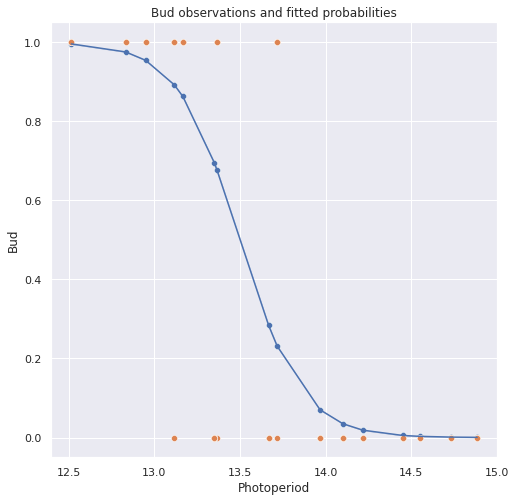

In [19]:
sns.scatterplot( data=chasm, x="Photoperiod", y="Fit_prob")
sns.lineplot( data=chasm, x="Photoperiod", y="Fit_prob")
sns.scatterplot( data=chasm, x="Photoperiod", y="Bud" )
plt.ylabel("Bud")
plt.title("Bud observations and fitted probabilities")
plt.savefig("chasm_fit.png")

<AxesSubplot:xlabel='Photoperiod', ylabel='Bud'>

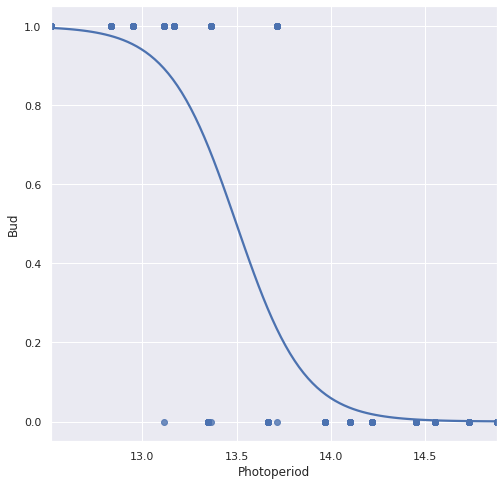

In [20]:
sns.regplot(data=chasm, x="Photoperiod", y="Bud", logistic=True, ci=None)

In [21]:
chasm["Likelihood"] = (chasm.Fit_prob**chasm.Bud)*((1-chasm.Fit_prob)**(1-chasm.Bud))
chasm

,Photoperiod,Bud,Null_prob,Fit_prob,Likelihood
1,12.833333,1,0.41875,0.975390,0.975390
3,13.166667,1,0.41875,0.862713,0.862713
4,13.366667,0,0.58125,0.675466,0.324534
7,13.716667,0,0.58125,0.231345,0.768655
9,13.966667,0,0.58125,0.070307,0.929693
...,...,...,...,...,...
311,13.116667,1,0.41875,0.892282,0.892282
312,13.350000,0,0.58125,0.695317,0.304683
314,13.666667,0,0.58125,0.284045,0.715955
316,14.100000,0,0.58125,0.034937,0.965063


In [22]:
max_likelihood = chasm["Likelihood"].product()
max_likelihood

3.532480672758708e-18

In [23]:
max_likelihood / null_likelihood

6.185161199884109e+29

In [24]:
np.log(max_likelihood)

-40.184531309595585

In [25]:
residual_deviance = -2*np.log(max_likelihood)
residual_deviance

80.36906261919117

In [26]:
G2 = -2*np.log( null_likelihood / max_likelihood)
G2

137.19424153073837

In [27]:
null_deviance - residual_deviance

137.19424153073837

In [28]:
chasm_fit.null_deviance - chasm_fit.deviance

137.1942415307384

In [29]:
1 - chi2.cdf(G2, df=1)

0.0

In [30]:
R2_M = 1 - (chasm_fit.deviance / chasm_fit.null_deviance)
R2_M

0.6305945851796477

In [31]:
chasm["Null_residual"] = chasm["Bud"] - pi_hat
chasm["Residual"] = chasm["Bud"] - chasm["Fit_prob"]
chasm["Difference"] = chasm["Fit_prob"] - pi_hat
R2_S = np.sum(chasm["Difference"]**2) / np.sum(chasm["Null_residual"]**2)
R2_S

0.6851756536416997

In [32]:
1 - ( np.sum( chasm["Residual"]**2 ) / np.sum(chasm["Null_residual"]**2) )

0.6508175736130917

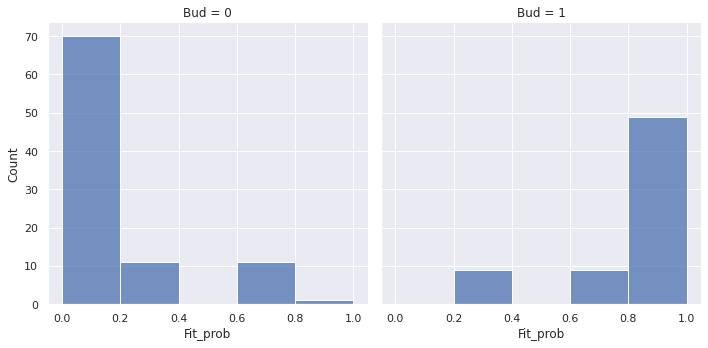

In [33]:
sns.displot( data=chasm, x="Fit_prob", col="Bud", binwidth=0.2)
plt.savefig("chasm_rd_hist.png")


In [37]:
fit_avgs = chasm.groupby("Bud").agg(Fit_average=('Fit_prob','mean'))
fit_avgs

,Fit_average
Bud,
0,0.139026
1,0.807023


In [41]:
R2_D = fit_avgs["Fit_average"][1] - fit_avgs["Fit_average"][0]
R2_D

0.6679966136273958